In [1]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import scikitplot.metrics as skplt
from sklearn.decomposition import TruncatedSVD
import pickle
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import math
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

/home/akash/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = sqlite3.connect('/home/akash/Downloads/amazon-fine-food-reviews/database.sqlite')
filtered_data = pd.read_sql_query('''select * from Reviews where Score != 3''', con)
#filtered_data.head()

In [3]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

In [4]:
actual_score = filtered_data['Score']
posneg = actual_score.map(partition)
filtered_data['Score'] = posneg

sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending= True, inplace= False, kind= 'quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]


In [5]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        break;
    i += 1;
    
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    
    
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")    

In [6]:
final_ = final.sample(frac=0.05492*2)#4)#1)#1.25 #1.5 #2 #2.5) #20k data points
#print(final_.shape)
# sorting data according to the time-stamp
data_sorted = final_.sort_values(by=['Time'], ascending=True)

data_sorted = data_sorted[['Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time',
       'Summary', 'Text', 'CleanedText', 'Score']]
print(data_sorted.shape)

(40001, 11)


In [7]:
#initial split
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(data_sorted['CleanedText'].values,data_sorted['Score'].values,test_size=0.3)

# BoW

In [8]:
count_vect = CountVectorizer()
X_tra = count_vect.fit_transform(X_train)
X_tes = count_vect.transform(X_test)
#print(X_train.shape)
#print(X_test.shape)


The optimal number of neighbors is 7.


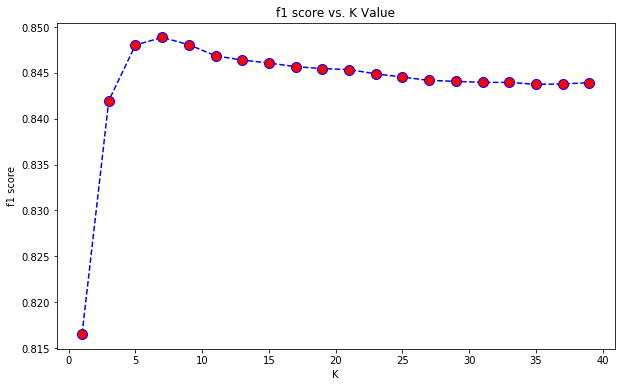

In [9]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))

cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=1, algorithm='brute')
    knn1.fit(X_tra, y_train)
    scores1 = cross_val_score(knn1, X_tra, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
#mse = [1-x for x in cv_scores1]    
        
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()
#print("the misclassification error for each k value is : ", np.round(mse,3))

k= 7 

Accuracy on test set: 84.693%
Precision on test set: 0.851
Recall on test set: 0.992
F1-Score on test set: 0.916
Confusion Matrix(test set):



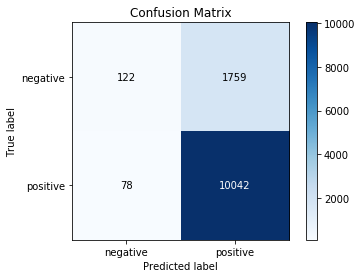

In [11]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1)
knn.fit(X_tra,y_train)
y_pred = knn.predict(X_tes)
print("k=", optimal_k1,"\n")
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)
#cnf = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
#sns.heatmap(cnf, annot=True,annot_kws={"size": 16}, fmt='g')

# KD Tree


The optimal number of neighbors is 23.


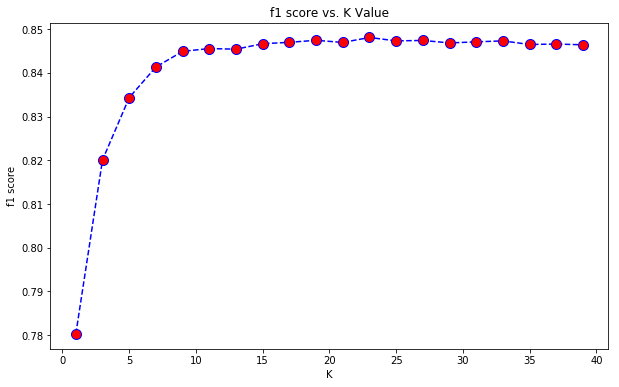

In [15]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))
svd = TruncatedSVD(n_components=100)
X_tra_svd = svd.fit_transform(X_tra)
cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=1, algorithm='kd_tree')
    knn1.fit(X_tra, y_train)
    scores1 = cross_val_score(knn1, X_tra_svd, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
#mse = [1-x for x in cv_scores1]    
        
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 83.668%
Precision on test set: 0.845
Recall on test set: 0.987
F1-Score on test set: 0.911
Confusion Matrix(test set):



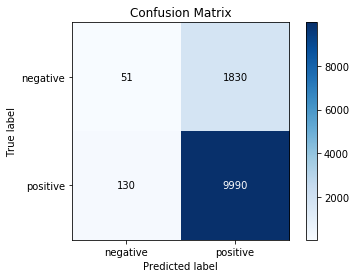

In [16]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1, algorithm='kd_tree')
X_te = svd.fit_transform(X_tes)
knn.fit(X_tra_svd,y_train)
y_pred = knn.predict(X_te)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

# tf-idf

In [17]:
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

# Brute force


The optimal number of neighbors is 9.


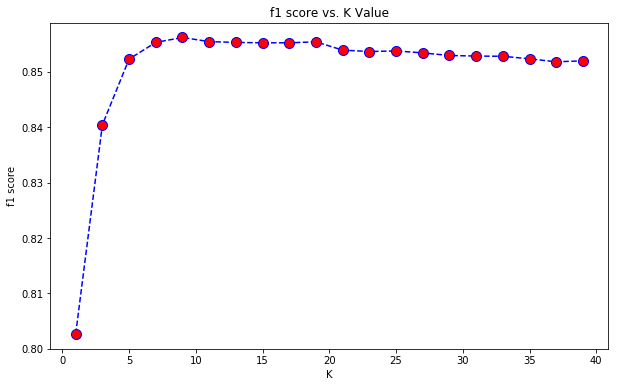

In [28]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))

cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='brute')
    knn1.fit(X_train_tfidf, y_train)
    scores1 = cross_val_score(knn1, X_train_tfidf, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 85.485%
Precision on test set: 0.860
Recall on test set: 0.988
F1-Score on test set: 0.920
Confusion Matrix(test set):



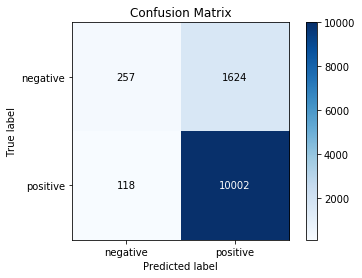

In [29]:
knn = KNeighborsClassifier(n_neighbors= optimal_k1, algorithm = 'brute')
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

# KD tree


The optimal number of neighbors is 9.


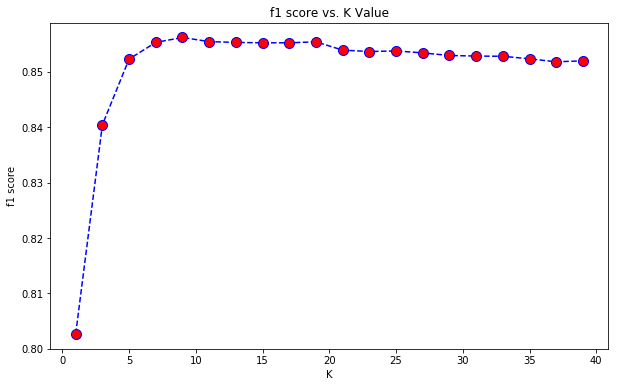

In [30]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='kd_tree')
    knn1.fit(X_train_tfidf_svd, y_train)
    scores1 = cross_val_score(knn1, X_train_tfidf, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 79.618%
Precision on test set: 0.847
Recall on test set: 0.926
F1-Score on test set: 0.885
Confusion Matrix(test set):



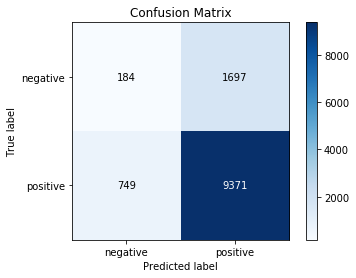

In [31]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1, algorithm='kd_tree')
X_test_svd = svd.fit_transform(X_test_tfidf)
knn.fit(X_train_tfidf_svd,y_train)
y_pred = knn.predict(X_test_svd)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

# W2V

In [8]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]

for sent in X_train:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [9]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=200, workers=4)

In [10]:
w2v_words = list(w2v_model.wv.vocab)

In [11]:
list_of_sent_test = []
for sent in X_test:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [12]:
w2v_model_test=gensim.models.Word2Vec(list_of_sent,min_count=5,size=200, workers=4)

In [13]:
w2v_words_test = list(w2v_model.wv.vocab)

# Avg W2V

In [14]:
sent_vectors_TRAIN = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(200)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TRAIN.append(sent_vec)
    
print(len(sent_vectors_TRAIN))
print(len(sent_vectors_TRAIN[0]))    
    
    
sent_vectors_TEST = []; 
for sent in list_of_sent_test: 
    sent_vec = np.zeros(200)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TEST.append(sent_vec)    

print(len(sent_vectors_TEST))
print(len(sent_vectors_TEST[0]))      

28000
200
12001
200


# Brute force


The optimal number of neighbors is 21.


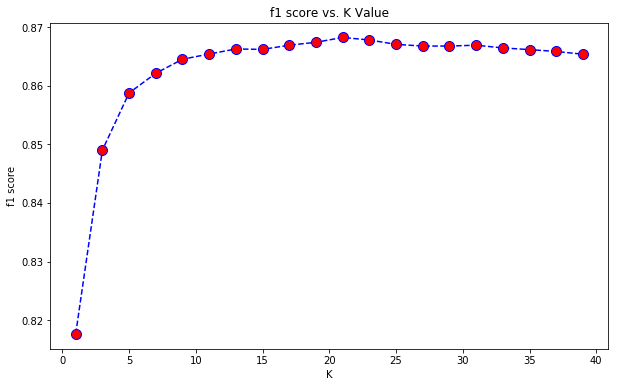

In [15]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))

cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='brute')
    knn1.fit(sent_vectors_TRAIN, y_train)
    scores1 = cross_val_score(knn1, sent_vectors_TRAIN, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 86.309%
Precision on test set: 0.873
Recall on test set: 0.980
F1-Score on test set: 0.923
Confusion Matrix(test set):



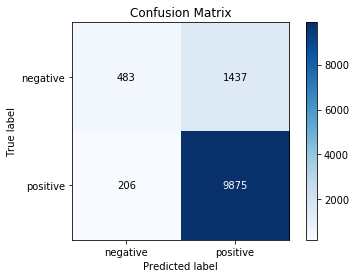

In [16]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1)
knn.fit(sent_vectors_TRAIN,y_train)
y_pred = knn.predict(sent_vectors_TEST)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

# KD tree


The optimal number of neighbors is 21.


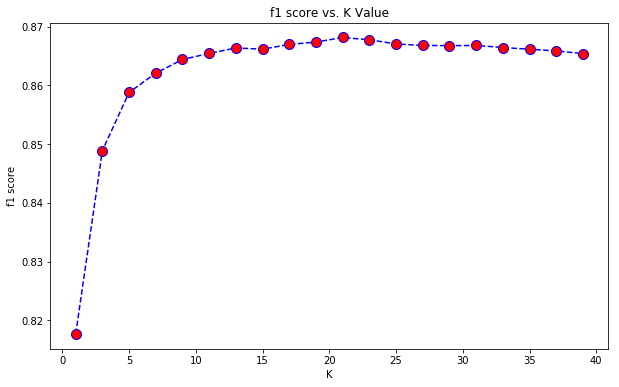

In [18]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))
svd = TruncatedSVD(n_components=100)
sent_vectors_TRAIN_svd = svd.fit_transform(sent_vectors_TRAIN)
cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=1, algorithm='kd_tree')
    knn1.fit(sent_vectors_TRAIN_svd, y_train)
    scores1 = cross_val_score(knn1, sent_vectors_TRAIN_svd, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    sent_vectors_TRAIN_svd
#mse = [1-x for x in cv_scores1]    
        
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 84.376%
Precision on test set: 0.853
Recall on test set: 0.983
F1-Score on test set: 0.914
Confusion Matrix(test set):



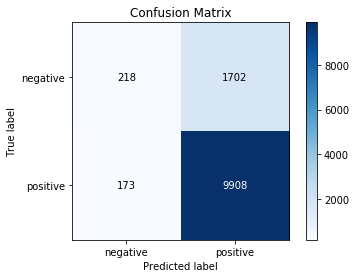

In [19]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1, algorithm='kd_tree')
X_test_svd = svd.fit_transform(sent_vectors_TEST)
knn.fit(sent_vectors_TRAIN_svd, y_train)
y_pred = knn.predict(X_test_svd)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

# Tf-Idf weighted W2V

In [21]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(final_['CleanedText'].values)

tfidf_feat = tfidf_vect.get_feature_names()

tfidf_sent_vectors_tr = []
row=0
for sent in list_of_sent: 
    sent_vec = np.zeros(200) 
    weight_sum =0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

In [22]:
tfidf_sent_vectors_TEST = [];
row=0
for sent in list_of_sent_test:  
    sent_vec = np.zeros(200) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TEST.append(sent_vec)
    row += 1    

# Brute force


The optimal number of neighbors is 33.


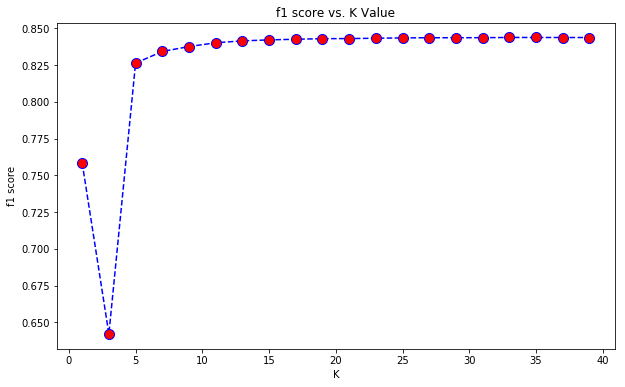

In [23]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))

cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm = 'brute')
    knn1.fit(tfidf_sent_vectors_tr, y_train)
    scores1 = cross_val_score(knn1, tfidf_sent_vectors_tr, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 83.985%
Precision on test set: 0.840
Recall on test set: 1.000
F1-Score on test set: 0.913
Confusion Matrix(test set):



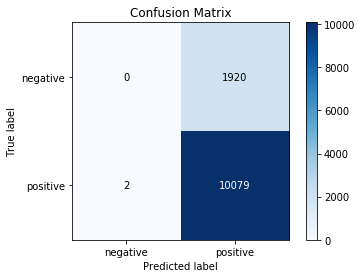

In [24]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1, algorithm='brute')
knn.fit(tfidf_sent_vectors_tr,y_train)
y_pred = knn.predict(tfidf_sent_vectors_TEST)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

# KD tree


The optimal number of neighbors is 33.


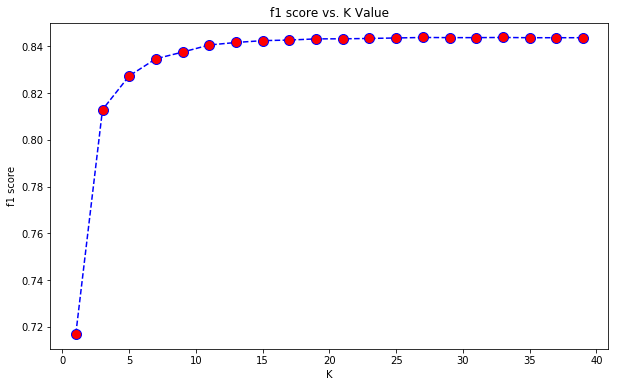

In [25]:
kn = list(range(0,40))
neighbors = list(filter(lambda x: x % 2 != 0, kn))
svd = TruncatedSVD(n_components=100)
tfidf_sent_vectors_tr_svd = svd.fit_transform(tfidf_sent_vectors_tr)
cv_scores1 = []
for k in neighbors:

    knn1 = KNeighborsClassifier(n_neighbors=k, n_jobs=1, algorithm='kd_tree')
    knn1.fit(tfidf_sent_vectors_tr_svd, y_train)
    scores1 = cross_val_score(knn1, tfidf_sent_vectors_tr_svd, y_train, cv=10, scoring='f1_micro')
    cv_scores1.append(scores1.mean())
    
#mse = [1-x for x in cv_scores1]    
        
optimal_k1 = neighbors[cv_scores1.index(max(cv_scores1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k1)

plt.figure(figsize=(10,6))
plt.plot(list(filter(lambda x: x % 2 != 0, kn)),cv_scores1,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
plt.title('f1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('f1 score')
plt.show()

Accuracy on test set: 84.001%
Precision on test set: 0.840
Recall on test set: 1.000
F1-Score on test set: 0.913
Confusion Matrix(test set):



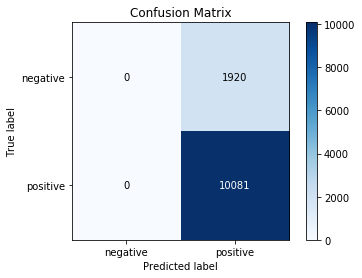

In [26]:
knn = KNeighborsClassifier(n_neighbors=optimal_k1, algorithm='kd_tree')
X_test_svd = svd.fit_transform(tfidf_sent_vectors_TEST)
knn.fit(tfidf_sent_vectors_tr_svd, y_train)
y_pred = knn.predict(X_test_svd)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))

print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label='positive')))

print("Confusion Matrix(test set):\n")
skplt.plot_confusion_matrix(y_test, y_pred)

In [2]:
from prettytable import PrettyTable
x = PrettyTable()
y = PrettyTable()
x.border = True
y.border = True
print("\n\n")
print("Algorithm : Brute Force")
x.field_names = ["Vectorization type", "Value of Hyperparameter", 
                 "Test Accuracy", "Precison", "Recall","F1 Score"]
x.add_row(["BoW","7","84.693","0.851","0.992","0.916"])
x.add_row(["TF-IDF","9","85.485","0.860","0.988","0.920"])
x.add_row(["Average W2V","21","86.309","0.873","0.980","0.923"])
x.add_row(["TF-IDF weighted W2V","33","83.985","0.840","1.000","0.913"])
print(x.get_string(),"\n\n\n\n")

print("Algorithm : KDTree")
y.field_names = ["Vectorization type", "Value of Hyperparameter", 
                 "Test Accuracy", "Precison", "Recall","F1 Score"]
y.add_row(["BoW","23","83.668","0.845","0.987","0.911"])
y.add_row(["TF-IDF","9","79.618","0.847","0.926","0.855"])
y.add_row(["Average W2V","21","84.376","0.853","0.983","0.914"])
y.add_row(["TF-IDF weighted W2V","33","84.001","0.840","1.000","0.913"])
print(y)




Algorithm : Brute Force
+---------------------+-------------------------+---------------+----------+--------+----------+
|  Vectorization type | Value of Hyperparameter | Test Accuracy | Precison | Recall | F1 Score |
+---------------------+-------------------------+---------------+----------+--------+----------+
|         BoW         |            7            |     84.693    |  0.851   | 0.992  |  0.916   |
|        TF-IDF       |            9            |     85.485    |  0.860   | 0.988  |  0.920   |
|     Average W2V     |            21           |     86.309    |  0.873   | 0.980  |  0.923   |
| TF-IDF weighted W2V |            33           |     83.985    |  0.840   | 1.000  |  0.913   |
+---------------------+-------------------------+---------------+----------+--------+----------+ 




Algorithm : KDTree
+---------------------+-------------------------+---------------+----------+--------+----------+
|  Vectorization type | Value of Hyperparameter | Test Accuracy | Precison |

# Conclusion

* Since 40k points are used, the results might not depict the performance of models on the complete data.
* Therefore, other performance metrices like f1 score are considered too.
* The max testing accuracy was attained by the Average W2V for both the algorithms.
* The max f1 score was highest for Avg W2V as well.
* Rest measures could be seen from the above performance tables.